In [51]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import re
import seaborn as sns

import urllib

from scipy import stats

</div>
<div class="1. Header" style='background-color:#08135c; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:white;">
       <h2>1. Data</h2>
        <h4>In this first section we import and rearrange the data.</h4>
    </span>
</div>
</div>

</div>
<div class="1.1 Header" style='background-color:#08135c; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:white">
       <h3>1.1 Data acquisition</h3>
    </span>
</div>
</div>
<div class="1.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        Here we load the relevant data using the <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">pd.read_csv()</span> method. The data we are dealing with follows a relational model. The specific navigation paths can be represented as graphs where the nodes concern the wikipedia pages that are connected through (directional) edges representing the hyperlinks.
    </span>
</div>

In [2]:
#Import relevant DataFrames

#Articles data
articles = pd.read_csv("data/articles.tsv", skiprows=11, names=["article"])
articles['article'] = articles['article'].apply(urllib.parse.unquote) #Parsing URL encoding

#Category data
categories = pd.read_csv("data/categories.tsv", sep="\t", skiprows=12, names=["article", "category"])
categories["article"] = categories["article"].apply(urllib.parse.unquote) #Parsing URL encoding

#Links data
links = pd.read_csv("data/links.tsv", sep="\t", skiprows=11, names=["article", "link"])
links["article"] = links["article"].apply(urllib.parse.unquote) #Parsing URL encoding
links["link"] = links["link"].apply(urllib.parse.unquote) #Parsing URL encoding

#Finished paths
paths_finished = pd.read_csv("data/paths_finished.tsv", sep="\t", skiprows=15, names=["hashedIpAddress",
                                                                                      "timestamp",
                                                                                      "durationInSec",
                                                                                      "path",
                                                                                      "rating"])
paths_finished["path"] = paths_finished["path"].apply(urllib.parse.unquote) #Parsing URL encoding

#Unfinished paths
paths_unfinished = pd.read_csv("data/paths_unfinished.tsv", sep="\t", skiprows=16, names=["hashedIpAddress",
                                                                                          "timestamp",
                                                                                          "durationInSec",
                                                                                          "path",
                                                                                          "target",
                                                                                          "type"])
paths_unfinished["path"] = paths_unfinished["path"].apply(urllib.parse.unquote) #Parsing URL encoding
paths_unfinished["target"] = paths_unfinished["target"].apply(urllib.parse.unquote) #Parsing URL encoding

# Add the length of the paths
paths_unfinished['pathLength'] = paths_unfinished['path'].apply(lambda x : len(str(x).split(';')))
paths_finished['pathLength'] = paths_finished['path'].apply(lambda x : len(str(x).split(';')))

#shortest path matrix
with open('data/shortest-path-distance-matrix.txt', 'r') as file:
    
    #Initialize shortest_path_distance list
    shortest_path_distance = []
    
    for line in file:
        
        #Check if the first character of the line is either a digit or underscore
        if re.search("([0-9]|_)", line[0]): 
            
            #Append list to shortest_path_distance
            shortest_path_distance.append([np.nan if x=='_' else int(x) for x in line.strip()])
    
#Convert to numpy ndarray
shortest_path_distance = np.array(shortest_path_distance) 

</div>
<div class="1.2 Header" style='background-color:#08135c; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:white">
       <h3>1.2 Data concatenation</h3>
    </span>
</div>
</div>
<div class="1.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        We want to merge both the <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">paths_finished</span> and <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">paths_unfinished</span> DataFrame. This make the analysis more convenient when comparing both types. More specifically we add the <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">target</span> column to and drop the <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">rating </span> column of <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">paths_finished</span>. We can then concatenate the respective DataFrames together. 
</div>

In [3]:
#Merge all the paths 
paths_finished['target'] = paths_finished['path'].apply(lambda x : str(x).split(';')[-1])

#Add and remove (ir)relevant colums.
paths_finished_ = paths_finished.copy()
paths_unfinished_ = paths_unfinished.copy()
paths_finished_['type'] = 'finished'
paths_finished_ = paths_finished_.drop('rating',axis =1)

#concatenate data
paths_all = pd.concat([paths_finished_, paths_unfinished_]) 

#print head of resulting DataFrame
paths_all.head(4)

,hashedIpAddress,timestamp,durationInSec,path,pathLength,target,type
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,9,African_slave_trade,finished
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,5,African_slave_trade,finished
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,8,African_slave_trade,finished
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,4,Greece,finished


</div>
<div class="4. Header" style='background-color:#08135c; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:white;">
       <h2>1. Between game analysis</h2>
        <h4>Here we will focus on the level of an individual player and the history of the different Wikispeedia games (i.e. between game) that have been played by that person consecutively.</h4>
    </span>
</div>
</div>

</div>
<div class="1.1 explanation" style='background-color:#08135c; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:white">
       <h3>1.1 Game distribution per player</h3>
    </span>
</div>
</div>
<div class="1.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        We can globally categorize the <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">between_game</span> game history (chronologically) in 3 groups:
        <ul>
            <li> <code class='python'>finished</code>: The player's last game was a <code class='python'>finished</code> path (e.g. <code class='python'>[timeout, restart, finished]</code>)</li>
            <li> <code class='python'>timeout</code>: The player's last game was a <code class='python'>finished</code> timeout (e.g. <code class='python'>[timeout, restart, timeout]</code>)</li>
            <li> <code class='python'>restart</code>: The player's last game was a <code class='python'>finished</code> restart (e.g. <code class='python'>[timeout, restart, restart]</code>)</li>
        </ul>
        Per category, we want to find and display the distribution for the number of succesfully <code class='python'>finished</code> games. Firsts we need to extract the  <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">between_game</span> history per player. From that, we can extract the <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">last_game</span> and <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">nb_finished_games</span> columns. Here we assume that the <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">hashedIpAddress</span> refers the a single unique player.
    </span>
</div>


In [4]:
#Create DataFrame with chronological (between_game) history of games player
players_record = pd.DataFrame(paths_all.sort_values('timestamp').groupby('hashedIpAddress')['type'].apply(list))
players_record = players_record.rename(columns={'type': 'between_game'})

#Display snipped of result
players_record.head(4)

,between_game
hashedIpAddress,
000386124f307de8,"[finished, timeout]"
0007183207b6008f,"[finished, finished, finished]"
000a09e202e88d10,[finished]
000a5bac5b7781ea,[finished]


In [5]:
#Now extract last_game column
players_record['last_game'] = players_record['between_game'].apply(lambda l : l[-1])

#Now extract nb_finished_games, nb_restart_games and nb_timeout_games and nb_total_games column
players_record['nb_finished_games'] = players_record['between_game'].apply(lambda x: x.count('finished'))
players_record['nb_restart_games'] = players_record['between_game'].apply(lambda x: x.count('restart'))
players_record['nb_timeout_games'] = players_record['between_game'].apply(lambda x: x.count('timeout'))
players_record['nb_total_games'] = players_record['between_game'].apply(lambda x: len(x))

#Display snipped of results
players_record.head(10)

,between_game,last_game,nb_finished_games,nb_restart_games,nb_timeout_games,nb_total_games
hashedIpAddress,,,,,,
000386124f307de8,"[finished, timeout]",timeout,1,0,1,2
0007183207b6008f,"[finished, finished, finished]",finished,3,0,0,3
000a09e202e88d10,[finished],finished,1,0,0,1
000a5bac5b7781ea,[finished],finished,1,0,0,1
000a6e585b776c96,[timeout],timeout,0,0,1,1
000bc9fe5640ed31,"[finished, finished]",finished,2,0,0,2
000d397013f09039,"[finished, finished]",finished,2,0,0,2
000e5d4c2c8e921f,"[finished, restart, restart, timeout]",timeout,1,2,1,4
000e954305ddb434,[finished],finished,1,0,0,1


<div class="1.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        Let's now compare the <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">between_game</span> for the different players. We first want look at the following two extremes:
        <ul>
            <li> Players that <b>only</b> contain <code class='python'>finished</code> games in their <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">between_game</span> history </li>
            <li> Players that contain <b>no</b> <code class='python'>finished</code> games in their <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">between_game</span> history at all</li>
        </ul>
    </span>
</div>

Type                                        Number           Percentage
Total number of unique players		:   20867            100%
Players with finished games only	:   9382             45%
Player with no finished games at all	:   6623             32%
Remaining players			:   4862             23%


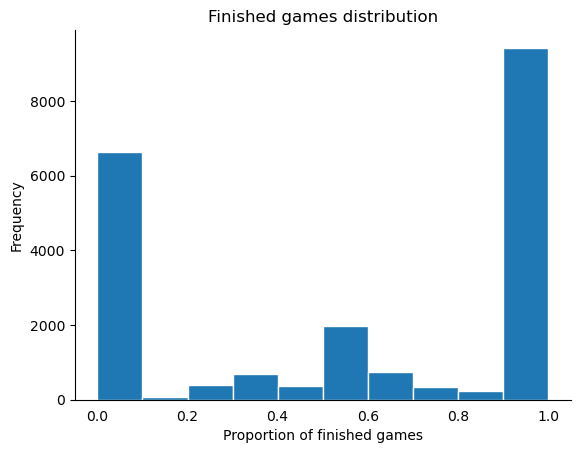

In [144]:
#Compute number of players in total
nb_players = len(players_record)

#Compute number of player that only contain finished games in their between_game history
nb_finished_only = len(players_record[players_record['nb_finished_games'] == players_record['nb_total_games']])

#Compute number of player contain no finished games in their between_game history at all
nb_finished_none = len(players_record[players_record['nb_finished_games'] == 0])

#Print results
print('{} {:>45} {:>20}'.format('Type', 'Number', 'Percentage'))
print('Total number of unique players\t\t: {:>7} {:>14.0f}%'.format(nb_players, nb_players/nb_players * 100))
print('Players with finished games only\t: {:>6} {:>14.0f}%'.format(nb_finished_only, nb_finished_only/nb_players * 100))
print('Player with no finished games at all\t: {:>6} {:>14.0f}%'.format(nb_finished_none, nb_finished_none/nb_players * 100))
print('Remaining players\t\t\t: {:>6} {:>14.0f}%'.format(nb_players-nb_finished_only-nb_finished_none, (nb_players-nb_finished_only-nb_finished_none)/nb_players * 100))

#Display histogram for visualization
fig, ax = plt.subplots()
plt.title('Finished games distribution')
ax.hist(players_record['nb_finished_games']/players_record['nb_total_games'], edgecolor=(1,1,1))
ax.set_ylabel('Frequency')
ax.set_xlabel('Proportion of finished games')
ax.tick_params(bottom=False);
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

<div class="1.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        Hence we observe that a substantial <b>32%</b> of the total number of players do not have any finished game at all!!! This is a big loss! Imagine if this portion would also have had succesful attempts (i.e. <code class='python'>finished</code> games). Then there would have been much more data on <code class='python'>finished</code> games to do further analysis on. Hence, we would like to find out why they stopped playing in the first place. This can help in finding strategies to keep these players engaged to potentially generate more data on <code class='python'>finished</code> games. <br><br> Let's first dig deeper into the players with no <code class='python'>finished</code> games at all. We want to get a sense of what their <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">between_game</span> history looks like.
    </span>
</div>

</div>
<div class="1.1 explanation" style='background-color:#08135c; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:white">
       <h3>1.2 Between game history of players with no <code class='python'>finished</code> games at all.</h3>
    </span>
</div>
</div>
<div class="1.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        In this we select the players with no <code class='python'>finished</code> games at all followed by analyzing their <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">between_game</span> history.
    </span>
</div>


In [68]:
#Display snipped of players with no finished games at all
players_record[players_record['nb_finished_games'] == 0][['between_game', 'nb_total_games']].head(5)

,between_game,nb_total_games
hashedIpAddress,,
000a6e585b776c96,[timeout],1
0011acb93ed0090b,"[restart, timeout]",2
001556137480170f,[timeout],1
0015865e516d4932,[restart],1
00210d6f590f218c,[timeout],1


<div class="1.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        We first want to visualize the number of attempt/games played by these players.
    </span>
</div>

#games     proportion
1          0.7895
2          0.1546
3          0.0382
4          0.0119
5          0.0042
6          0.0008
7          0.0005
8          0.0002
10         0.0002


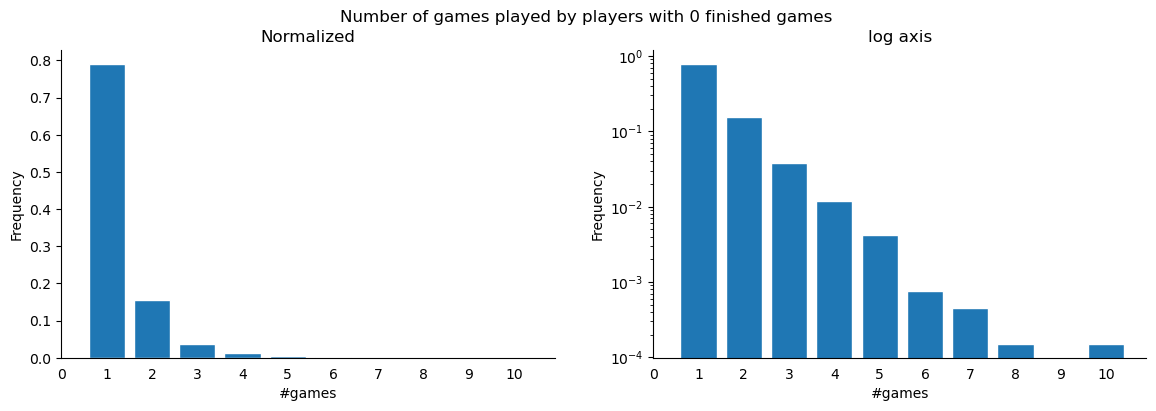

In [151]:
#Extract distribution of number of attempts/games
number_attemps_dist = players_record[players_record['nb_finished_games'] == 0]['nb_total_games'].value_counts(normalize=True)

#Print results
print('{:<10} {}'.format('#games', 'proportion'))
for g, p in number_attemps_dist.items():
      print('{:<10} {:<5.4f}'.format(g, p))
        
#Visualize distribution
fig, ax = plt.subplots(1,2, figsize=(14,4))
plt.suptitle('Number of games played by players with 0 finished games')
ax= ax.ravel()

#Number of games distrubiton on default axis
ax[0].bar(number_attemps_dist.index, number_attemps_dist, edgecolor=(1,1,1))
ax[0].set_title('Normalized')
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('#games')
ax[0].tick_params(bottom=False);
ax[0].set_xticks(range(max(number_attemps_dist.index)+1));
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)

#Number of games distrubiton on log axis
ax[1].bar(number_attemps_dist.index, number_attemps_dist, edgecolor=(1,1,1), log=True)
ax[1].set_title('log axis')
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('#games')
ax[1].tick_params(bottom=False);
ax[1].set_xticks(range(max(number_attemps_dist.index)+1));
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)

<div class="1.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        Hence we find that the number of games played by players with 0 finished games follows a power-law. Thus the majority (79%) only has 1 attempt that is either a <code class='python'>restart</code> or a <code class='python'>timeout</code>. Does this mean that this single attempt is so frustrating that the player decides to terminate and never come back? To further investigate this we have to specifically look into their <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">in_game</span> paths.<br><br>
        Let's first look at the <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">pathLength</span> distribution of these single attemps.
    </span>
</div>

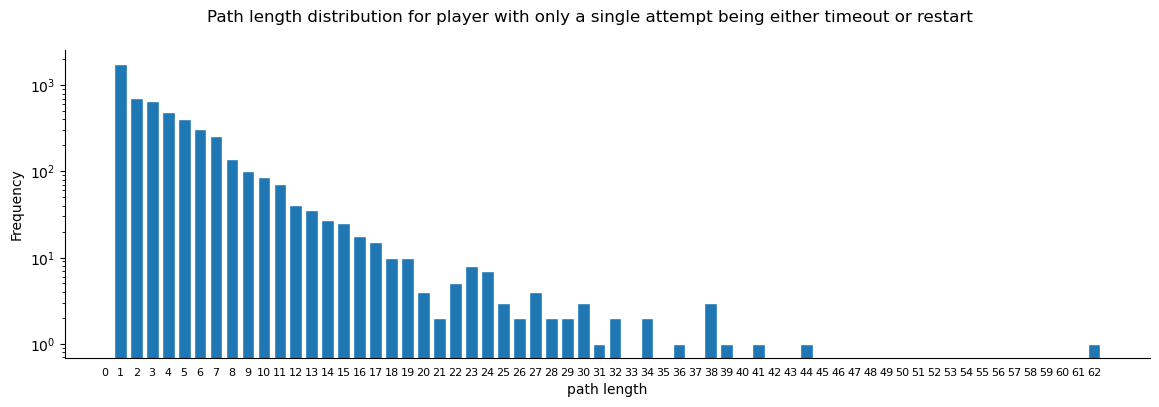

In [198]:
#Get all the hashedIpaddress of the players that have only 1 attempt that is either a restart or timeout
hashedIpaddress_selection = players_record[(players_record['nb_finished_games'] == 0) & (players_record['nb_total_games'] == 1)].index

#Extract path lengths
path_lengths_selection = paths_all.set_index('hashedIpAddress').loc[hashedIpaddress_selection]['pathLength'].value_counts()

#Display histogram for visualization
fig, ax = plt.subplots(figsize=(14,4))
plt.suptitle('Path length distribution for player with only a single attempt being either timeout or restart')

#Number of games distrubiton on log axis
ax.bar(path_lengths_selection.index, path_lengths_selection, edgecolor=(1,1,1), log=True)
ax.set_ylabel('Frequency')
ax.set_xlabel('path length')
ax.tick_params(bottom=False);
ax.set_xticks(range(max(path_lengths_selection.index)+1));
ax.tick_params(axis='x', which='major', labelsize=8)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

<div class="1.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        In the remainder of the analysis, we will discard entries with a <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">pathLength</span> of 1. We assume an attempt is only "serious" once a player has traversed to at least one other Wikipedia page. In the next section (for now in the other .ipynb notebooks) we will perform a more thorough analysis on the paths taken by these specific players. More specifically we will compare this to finished attempts of other players to see what differences we observe.
    </span>
</div>

</div>
<div class="1.1 explanation" style='background-color:#08135c; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:white">
       <h3>1.3 Between game history of players with partial <code class='python'>finished</code> games.</h3>
    </span>
</div>
</div>
<div class="1.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        <b>Hi Tamara, here I will just write down some ideas that I can come up with. Of course you might add or change some ideas if you think it would be better.</b><br><br>
        So far we have just looked at players that have 0 <code class='python'>finished</code> games at all right? This was, as said 32% of the data. We use this group to answer the question why people are not able to finish a game and likely never return after being frustrated (for this probably Mathieu and Mengjie have to further analyze the exact paths taken. In other words the <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">in_game</span> history is interesting here).<br><br> 
        We also, however, have 23% of the players that have a mix of <code class='python'>finished</code>, <code class='python'>timeout</code> and <code class='python'>restart</code> in their <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">between_game</span> history. Maybe here we can find interesting information concerning the interaction between these different games. So here the <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">between_game</span> history in addition to <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">in_game</span> can be interesting. Perhaps people are likely to have a <code class='python'>restart</code> game after some succesful <code class='python'>finished</code> paths, however after many more restarts likely <code class='python'>timeout</code>? I see you did some anlaysis on this on the code below, I think the approach you did is nice. We can discuss if further on the phone if yo want. <br><br>
        The last group that comprise 45% of all players only have <code class='python'>finished</code> games. I am not sure what we can do here with regard to <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">between_game</span> history. I think just group act as some sort of benchmark to compare our <code class='python'>restart</code> and <code class='python'>timeout</code> games to.<br><br>
        Overall we should not overcomplicate things and start of with an easy model. From there on we can extend our anlaysis if we want. Therefore I suggest for us to now stick to the following:
        <ul>
            <li> Continue working on the 32% of people with 0 <code class='python'>finished</code> games. (still not to cut out the individual with <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">pathLength</span> of 0 for example.) </li>
            <li> Look for interaction between the different games as I said. You can filter out the 23% using the code I put below. Maybe we should only focus on the people that end with <code class='python'>restart</code> of <code class='python'>temout</code> here. This would be a smaller fraction of the 23%.</li>
        </ul>
    </span>
</div>


## Some template code below (variable naming etc. not too good. This is just to give an idea)

In [195]:
#Display snipped of players with within the 23% category
partially_finished = players_record[(players_record['nb_finished_games'] != 0) & (players_record['nb_finished_games'] != players_record['nb_total_games'])]
partially_finished.head(10)


,between_game,last_game,nb_finished_games,nb_restart_games,nb_timeout_games,nb_total_games
hashedIpAddress,,,,,,
000386124f307de8,"[finished, timeout]",timeout,1,0,1,2
000e5d4c2c8e921f,"[finished, restart, restart, timeout]",timeout,1,2,1,4
00381d0a21b8ba73,"[restart, finished, finished, finished, finish...",finished,5,1,0,6
003a34e80bdab60d,"[restart, finished]",finished,1,1,0,2
003de5ad49bf14e9,"[finished, timeout]",timeout,1,0,1,2
0045bac960aed861,"[restart, restart, restart, restart, finished,...",timeout,8,11,2,21
0068f6c30855b1fd,"[finished, finished, restart, finished, finish...",restart,4,2,0,6
007519dc19b7e34e,"[finished, timeout]",timeout,1,0,1,2
007b13af674035a0,"[restart, finished, restart, restart, restart,...",timeout,2,4,1,7


In [206]:
#Let's check what type of games these players usually end on
game_end = partially_finished['last_game'].value_counts(normalize=True)
game_end

timeout     0.539079
finished    0.332374
restart     0.128548
Name: last_game, dtype: float64

In [207]:
game_end['timeout']

0.5390785684903332

<div class="1.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        Most people ended on a <code class='python'>timeout</code> or <code class='python'>finished</code>. So this suggests that people that go for a restart are usually motivated to give it another try?
    </span>
</div>

In [209]:
#Proportion of total number of players when selecting further for people that end on timeout or restart
prop_final = (nb_players-nb_finished_only-nb_finished_none)/nb_players * 100 * (game_end['timeout']+game_end['restart'])
print('People ending on timeout or restart in this group is: {:.0f}%'.format(prop_final))

People ending on timeout or restart in this group is: 16%


<div class="1.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        So in total we have 32 + 16 = 48% of the players ending on a <code class='python'>timeout</code> or <code class='python'>restart</code>.
    </span>
</div>

<br><br><br><br> 
### Below is Tamara's original code





</div>
<div class="1.1 explanation" style='background-color:#08135c; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:white">
       <h3>1.2 Data processing game distribution per player</h3>
    </span>
</div>
</div>
<div class="1.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        There are some players that played several thousand times. The question is if they will be taken into account? Maximum ist at 4'685 so very high. Til what number should we take them into account? What is reasonable?
       Mels do you have an idea what Treshold to set or if we have to analyze it? For the restart and the timeout in the last, the distributions are more similar
    </span>
</div>


In [126]:
test =players_record[players_record['last_game']== 'finished']

In [127]:
players_record[players_record['nb_finished_games'] > 100].head(10)

,between_game,last_game,nb_finished_games,nb_restart_games,nb_timeout_games,nb_total_games
hashedIpAddress,,,,,,
0299542414c3f20a,"[finished, finished, finished, finished, finis...",finished,172,0,0,172
0d57c8c57d75e2f5,"[finished, finished, finished, finished, finis...",finished,4865,0,0,4865
101779c07d4d00f0,"[finished, finished, finished, finished, finis...",finished,139,0,0,139
26f76e394525328e,"[restart, restart, finished, finished, restart...",timeout,107,146,17,270
321e4b101c5b58ff,"[finished, finished, finished, finished, finis...",finished,196,0,0,196
473d6ac602c2b198,"[finished, finished, finished, finished, finis...",finished,545,56,36,637
5590014e126275b4,"[finished, finished, finished, finished, finis...",finished,110,0,0,110
58f1667d434c79f1,"[finished, finished, finished, finished, finis...",finished,118,0,0,118
5bb5836b425e6bfe,"[timeout, finished, finished, finished, finish...",restart,243,41,24,308


In [128]:
players_record[players_record['nb_restart_games'] > 100].head(10)

,between_game,last_game,nb_finished_games,nb_restart_games,nb_timeout_games,nb_total_games
hashedIpAddress,,,,,,
26f76e394525328e,"[restart, restart, finished, finished, restart...",timeout,107,146,17,270
75bd20c663d02c8f,"[restart, restart, restart, finished, restart,...",restart,145,119,33,297


Distribution of the finished paths. Can show the same for the other distributions, just change the test dataframe below

In [129]:
test =players_record[players_record['last_game']== 'timeout']

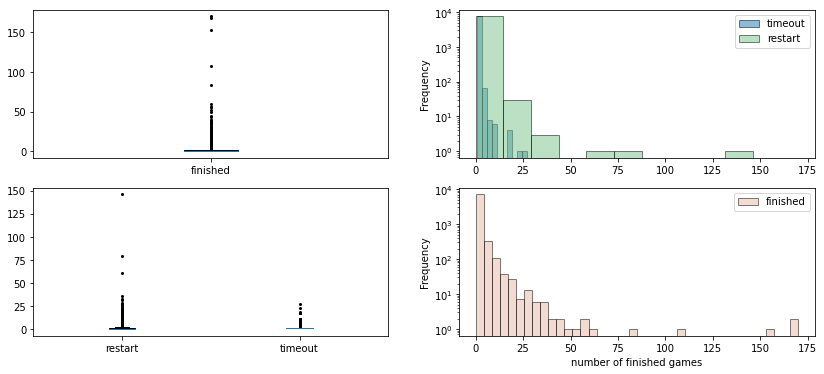

In [130]:
fig = plt.figure(figsize=(14,6))

ax = plt.subplot(2,2,1)
ax.boxplot(test['nb_finished_games'], patch_artist=True, flierprops=flierprops, boxprops=boxprops, medianprops=medianprops, labels=['finished']);
xlim = ax.get_xlim();

ax = plt.subplot(2,2,3)
ax.boxplot([test['nb_restart_games'], test['nb_timeout_games']], patch_artist=True, flierprops=flierprops, boxprops=boxprops, medianprops=medianprops, labels=['restart','timeout'])
xlim = ax.get_xlim();


ax = plt.subplot(2,2,4)
test.plot(y='nb_finished_games', kind='hist', legend=False, edgecolor=(0,0,0, 0.5), bins=40, ax=ax, log=True, color=(235/255, 184/255, 164/255, 0.5), label="finished")
ax.legend();
ax.set_xlabel('number of finished games')
xlim = ax.get_xlim();

ax = plt.subplot(2,2,2)
test.plot(y='nb_timeout_games', kind='hist', legend=False, edgecolor=(0,0,0, 0.5), ax=ax, log=True, color=(31/255, 119/255, 180/255, 0.5), label="timeout")
test.plot(y='nb_restart_games', kind='hist', legend=False, edgecolor=(0,0,0, 0.5), ax=ax, log=True, color=(120/255, 194/255, 139/255, 0.5), label="restart")
ax.legend();
ax.set_xlim(xlim);

In [131]:
test['nb_finished_games'].describe()

count    7654.000000
mean        1.285733
std         4.922636
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max       170.000000
Name: nb_finished_games, dtype: float64

In [132]:
test['nb_restart_games'].describe()

count    7654.000000
mean        0.933499
std         2.933987
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max       146.000000
Name: nb_restart_games, dtype: float64

In [133]:
test['nb_timeout_games'].describe()

count    7654.000000
mean        1.131043
std         0.779118
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        27.000000
Name: nb_timeout_games, dtype: float64

</div>
<div class="1.1 explanation" style='background-color:#08135c; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:white">
       <h3>1.3 Calculate percentage of people that had restart/timeout/finished path before the final part for every possible outcome</h3>
    </span>
</div>
</div>
<div class="1.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        What data do we want to include? When someone did a timeout and comes bad, do we take them into account? Or do we have to filter them out?
    </span>
</div>


In [134]:
timeout = players_record[players_record['last_game']== 'timeout']
percentage_finished = len(timeout[timeout['nb_finished_games']> 0])/len(timeout)
percentage_restart = len(timeout[timeout['nb_restart_games']> 0])/len(timeout)
percentage_timeout = len(timeout[timeout['nb_timeout_games']> 1])/len(timeout)
print('Percentage of users that finished a path before a timeout: ',percentage_finished)
print('Percentage of users that restarted a path before a timeout: ',percentage_restart)
print('Percentage of users that had a timeout before the final timeout: ',percentage_timeout)

Percentage of users that finished a path before a timeout:  0.3424353279331069
Percentage of users that restarted a path before a timeout:  0.36007316435850534
Percentage of users that had a timeout before the final timeout:  0.06924483929971256


In [135]:
restart = players_record[players_record['last_game']== 'restart']
percentage_finished = len(restart[restart['nb_finished_games']> 0])/len(restart)
percentage_timeout = len(restart[restart['nb_timeout_games']> 0])/len(restart)
percentage_restart = len(restart[restart['nb_restart_games']> 1])/len(restart)
print('Percentage of users that finished a path before the end restart: ',percentage_finished)
print('Percentage of users that did a timeout of a path before the end restart: ',percentage_timeout)
print('Percentage of users that had a restart before the final restart: ',percentage_restart)

Percentage of users that finished a path before the end restart:  0.28216704288939054
Percentage of users that did a timeout of a path before the end restart:  0.042437923250564336
Percentage of users that had a restart before the final restart:  0.3110609480812641


In [136]:
finished = players_record[players_record['last_game']== 'finished']
percentage_restart = len(finished[finished['nb_restart_games']> 0])/len(finished)
percentage_timeout = len(finished[finished['nb_timeout_games']> 0])/len(finished)
percentage_finished = len(finished[finished['nb_finished_games']> 1])/len(finished)
print('Percentage of users that restarted a path before the finished path: ',percentage_restart)
print('Percentage of users that did a timeout of a path before the finished path: ',percentage_timeout)
print('Percentage of users that had a finished path before the final finished path: ',percentage_finished)

Percentage of users that restarted a path before the finished path:  0.14229859974540826
Percentage of users that did a timeout of a path before the finished path:  0.021185670121840333
Percentage of users that had a finished path before the final finished path:  0.4891798508819785


</div>
<div class="1.1 explanation" style='background-color:#08135c; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:white">
       <h3>1.4 General preprocessing of data</h3>
    </span>
</div>
</div>
<div class="1.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
       takes out everything that has zero pathlength -> can I do on monday
    </span>
</div>
